In [2]:
# Tool to convert Label to JSON

# Load dependancies
from tkinter import filedialog
from tkinter import * # File dialog
import os
import matplotlib.pyplot as plt # For plotting
import numpy as np
from shutil import copyfile # Copy file
import cv2
from skimage.color import rgb2gray
from skimage import img_as_ubyte
from skimage import measure
from skimage.measure import approximate_polygon
import glob # For importing multiple files
import json

In [3]:
# User input
# Folder structure:

# -- SELECTED MAIN FOLDER
#    img_1
#    img_n
#    -- mask
#       mask_1
#       mask_n

# Select file type for import
select_ext = '*.png'
# Define output file type
output_ext = '.JSON'
# Define suffix
suffix = '_label'

# Object profile
prof = 'PROFILE'
obj_prof = 'hollow'

# Quality
qual = 'QUALITY'
obj_qual = 'good' # == 1
# Remaining are bad == 0

# Binary class == 1l
binary_class = 1

In [4]:
# Get user-specific folder selection
%gui tk
root = Tk()
root.withdraw()
root.update()
folder_selected = filedialog.askdirectory()
root.destroy() # Destroy root window

In [5]:
# Search for mask folder
folder_selected_mask = os.path.join(folder_selected, 'mask')
# Create a list with all loaded files (both lists should be synchronised. Solution: Sorting by name)
listFiles = sorted(glob.glob( os.path.join(folder_selected, select_ext) ) )
listFiles_mask = sorted( glob.glob( os.path.join(folder_selected_mask, select_ext) ) )

In [6]:
# Create a mask only with 1 class
# If multiple classes, loop through 1 class first (all contours in 1 class)
# then over images





In [7]:
f_img = listFiles_mask[0]
f_img = cv2.imread(f_img)
# Find unique RGB values for classes (not working for 1 color color)
uniques = np.unique(f_img.reshape(-1, f_img.shape[-1]), axis=0)
# If binary class, assign number of classes to 1
if len(uniques) == 256:
    num_classes = 1
    # Use pseudo color for binary class (create tuples)
    # uniques = [ (0,0,0), (255,255,255) ]
    # Remove black color (reserved for background)
    colors_trunc = [ (255,255,255) ]
    
else:
    # Number of classes
    num_classes = len(uniques)
    # Remove black color (reserved for background)
    colors_trunc = np.delete(uniques, (0), axis=0)
    # Convert array to tuple
    colors_trunc = [tuple(x) for x in colors_trunc.tolist()]

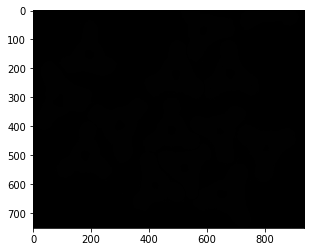

In [8]:
plt.imshow(f_img, cmap='gray')

In [9]:
listFiles_mask[0]

'/Users/daviddang/MASK_R-CNN_orig/Mask_RCNN/datasets/brilliant/train/mask/Z-Stack-Brilliant_Raw_v2_z01.png'

In [10]:
num_classes

2

In [11]:
# FINAL

# Loop through images
    # Loop through regions
    # Craete JSON dict

counter = 0

# Set k for child contour
k = -1

# Get number of images from list
n_img = len(listFiles)
main_dict = {}  
for ii in range (0, n_img):
    counter = counter + 1
    # Get file path from list
    filename = listFiles_mask[ii]
    # Get filename from original file
    filename_orig = listFiles[ii]
    # Read image
    img = cv2.imread(filename)
    # Get file size - needed for JSON
    f_size = os.path.getsize(filename_orig)
    # Get filname without path
    th_fname = os.path.basename(filename_orig)
    # Swap BGR to RGB
    t_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Find unique RGB values for classes
    uniques = np.unique(t_img.reshape(-1, t_img.shape[-1]), axis=0)
    # Number of classes
    num_classes = len(uniques)
    
    # Obtain binary image by applying simple Threshold
    ret, thres_img = cv2.threshold(cv2.cvtColor(t_img, cv2.COLOR_RGB2GRAY),
                0, 255, cv2.THRESH_BINARY)
    
    ### Pre-processing: Remove 5 pixel particles

    # Find all your connected components (white blobs)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(thres_img, connectivity=8)
    # connectedComponentswithStats yields every seperated component with information on each of them, such as size
    # the following part is just taking out the background which is also considered a component, but most of the time we don't want that.
    sizes = stats[1:, -1]; nb_components = nb_components - 1

    # minimum size of particles we want to keep (number of pixels)
    min_size = 100  

    # Create new image excluding small particles
    bw1 = np.zeros((output.shape), np.uint8)
    #for every component in the image, you keep it only if it's above min_size
    for i in range(0, nb_components):
        if sizes[i] >= min_size:
            bw1[output == i + 1] = 255
            
    kernel_eros = np.ones((3,3),np.uint8)
    eros_bw = cv2.erode(bw1,kernel_eros,iterations = 1)
    ### Pre-processing: Use Dilation to close small gaps with foreground boundary
    kernel_dil = np.ones((2,2),np.uint8)
    dil_bw = cv2.dilate(eros_bw,kernel_dil,iterations = 1)
    ### Pre-processing: Close tiny wholes in foreground object
    kernel_cls = np.ones((2,2),np.uint8)
    clean_bw = cv2.morphologyEx(dil_bw, cv2.MORPH_CLOSE, kernel_cls)
        
    # Retrieves all of the contours and reconstructs a full hierarchy of nested contours
    #contours, hier = cv2.findContours(clean_bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Take external contours only
    contours, hier = cv2.findContours(clean_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    

    # Get number of contours
    n_contour = len(contours)
    
    # Preallocate empty dict
    region_dict = {}
    
    # Loop through contour in th-image
    for jj in range (0, n_contour):
        # Create empty canvas
        mask_cont = np.zeros(thres_img.shape,np.uint8)
        # Draw contours
        objectID = -1
        # For fill use -1, for line use 1
        line_thickness = 1
        # Set max value for contour
        contour_col = 255
        # Burn contour on mask
        cv2.drawContours(mask_cont, contours, objectID, contour_col, line_thickness)
        
        
        # Use Post-Processing to get a cleaner border 
        
        # kernel_dil2 = np.ones((5,5), np.uint8)
        # mask_cont = cv2.dilate(mask_cont, kernel_dil2, iterations = 3)
        # mask_cont = cv2.erode(mask_cont, kernel_dil2, iterations=3)
        # mask_cont = skeletonize(mask_cont/255)
        # contours_temp, hier_temp = cv2.findContours((mask_cont*255).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # mask_temp = np.zeros(t_img.shape,np.uint8)
        # cv2.drawContours(mask_temp, contours_temp, -1, 255, 2)
        
        # Get contour coordinates by keeping only non-zero values
        pixelpoints = np.transpose(np.nonzero(mask_cont))
        # pixelpoints column structure: X-Y
        # Flip columns to Y-X (for images)
        #y_coord = pixelpoints[:,0].tolist()
        #x_coord = pixelpoints[:,1].tolist()

        # OR:
        th_cont = contours[jj]
        th_cont = np.squeeze(th_cont)
        x_coord = th_cont[:,0].tolist()
        y_coord = th_cont[:,1].tolist()
        # (trunctated) dict for regions which will be added to the main JSON file ANNOTATION under 'regions'
        reg = {
            str(jj): {
              "shape_attributes": {
                "name": "polygon",
                "all_points_x": x_coord,
                "all_points_y": y_coord,
              },
              "region_attributes": {}
            }
        }
        region_dict.update(reg)
    
    # Main dict for JSON file for th-image
    annotation = {
        th_fname + str(f_size): {
        "fileref": "",
        "size": f_size,
        "filename": th_fname,
        "base64_img_data": "",
        "file_attributes": {},
        "regions": region_dict
        }
    }
    # Add main dict with all 'regions' (with x-y coordinates for polygons)
    main_dict.update(annotation)
    ### Print output
    print('Output: ##### Create JSON-dict: %d out of %d images. #####' % (counter, n_img) ) 
    
print('Output: ##### JSON-file saved. #####')
#print('Exported: ' + folder_selected)

# print(json.dumps(annotation, indent=4)) # JSON file won't overwrite
with open(os.path.join(folder_selected, 'via_region_data.json'), 'w', encoding='utf-8') as output_file:
    json.dump(main_dict, output_file, ensure_ascii=False, indent=4) 


Output: ##### Create JSON-dict: 1 out of 65 images. #####
Output: ##### Create JSON-dict: 2 out of 65 images. #####
Output: ##### Create JSON-dict: 3 out of 65 images. #####
Output: ##### Create JSON-dict: 4 out of 65 images. #####
Output: ##### Create JSON-dict: 5 out of 65 images. #####
Output: ##### Create JSON-dict: 6 out of 65 images. #####
Output: ##### Create JSON-dict: 7 out of 65 images. #####
Output: ##### Create JSON-dict: 8 out of 65 images. #####
Output: ##### Create JSON-dict: 9 out of 65 images. #####
Output: ##### Create JSON-dict: 10 out of 65 images. #####
Output: ##### Create JSON-dict: 11 out of 65 images. #####
Output: ##### Create JSON-dict: 12 out of 65 images. #####
Output: ##### Create JSON-dict: 13 out of 65 images. #####
Output: ##### Create JSON-dict: 14 out of 65 images. #####
Output: ##### Create JSON-dict: 15 out of 65 images. #####
Output: ##### Create JSON-dict: 16 out of 65 images. #####
Output: ##### Create JSON-dict: 17 out of 65 images. #####
Output